# Week 4 - Function 4 ((33DP, 4D))

# Setup
Let's load all the imports in the top to avoid repeating and simplify the readability of each solution.

In [1]:
import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel, WhiteKernel
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats.qmc import LatinHypercube
from ipywidgets import interact, FloatSlider

from utils.plotting_utils import (
    plot_4D_initial_data,
    plot_output_outliers,
    plot_nd_mean_uncertainty_slice
)

# Plan
We now have ((33, 4)) - 33DP & 4D that can be found `./data/week_4/function_4/`.

1. Load data
2. Preprocessing (StandardScaler — no outliers)
3. Build probabilistic Model (GP with ARD Matern)
4. Interactive GP visualization (2D slices)
5. Acquisition Function (UCB on LHS candidates)

# 1. Load data

In [2]:
X_train_raw = np.load(r"./data/week_4/function_4/inputs.npy")
y_train_raw = np.load(r"./data/week_4/function_4/outputs.npy")
print(f"Shape: X={X_train_raw.shape}, y={y_train_raw.shape}")
print(f"X range: [{X_train_raw.min():.4f}, {X_train_raw.max():.4f}]")
print(f"y range: [{y_train_raw.min():.2e}, {y_train_raw.max():.2e}]")

Shape: X=(33, 4), y=(33,)
X range: [0.0063, 0.9995]
y range: [-3.75e+01, 4.01e-01]


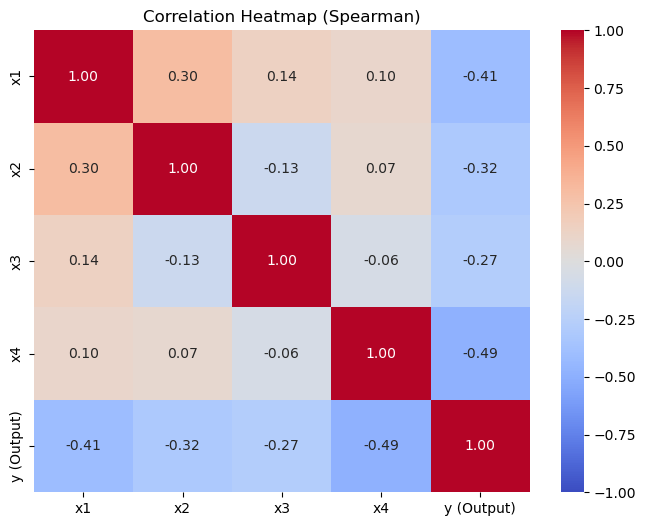

Generating Pairplot...


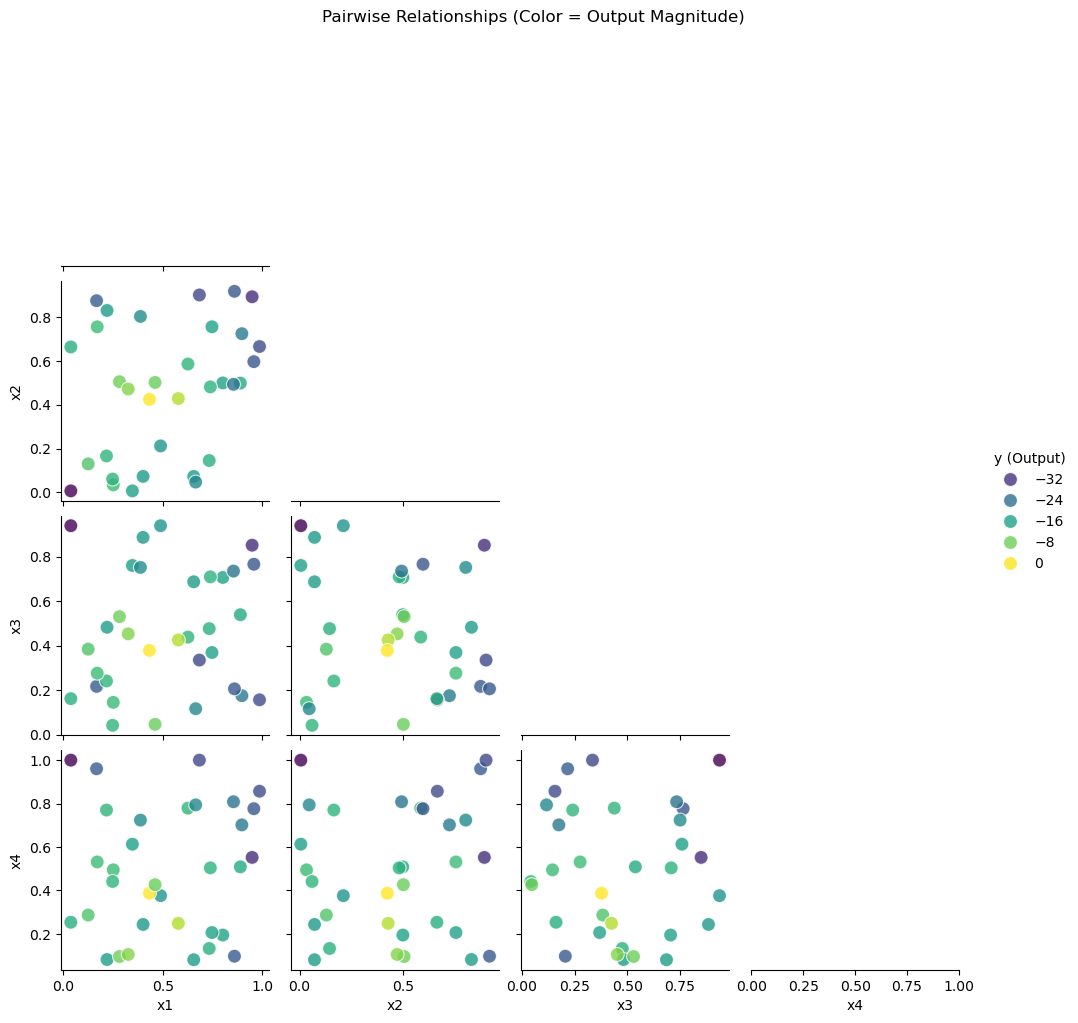

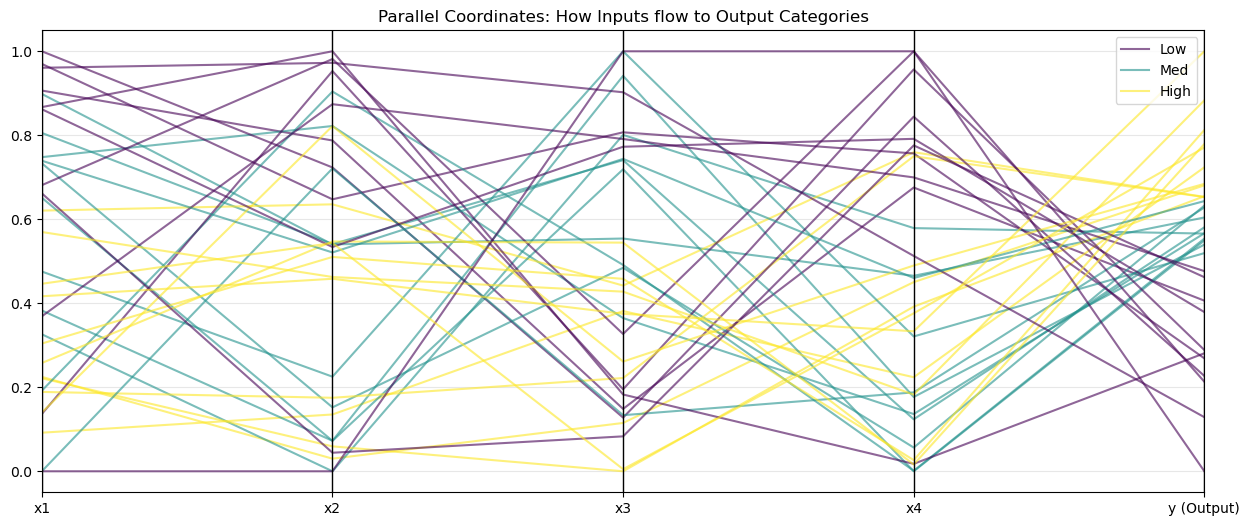

In [3]:
plot_4D_initial_data(X_train_raw, y_train_raw, "Step1: Data points", f"""
DATA SUMMARY
{'='*80}
Points: {len(X_train_raw)}
Input shape: {X_train_raw.shape}
Output shape: {y_train_raw.shape}


CURRENT BEST
{'='*80}
Current best: {np.max(y_train_raw)}
At input: {X_train_raw[np.argmax(y_train_raw)]}
""")

# 2. Preprocessing

No outliers detected, so StandardScaler is appropriate for the output.

In [4]:
scaler_X = MinMaxScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train_raw)
y_train = scaler_y.fit_transform(y_train_raw.reshape(-1, 1)).ravel()

print(f"Total points: {len(X_train)}")
print(f"Scaled y range: [{y_train.min():.2f}, {y_train.max():.2f}]")
print(f"Best point: X={X_train_raw[np.argmax(y_train_raw)]}, y={y_train_raw.max():.2e}")

Total points: 33
Scaled y range: [-2.46, 2.10]
Best point: X=[0.43274  0.424865 0.378558 0.387505], y=4.01e-01


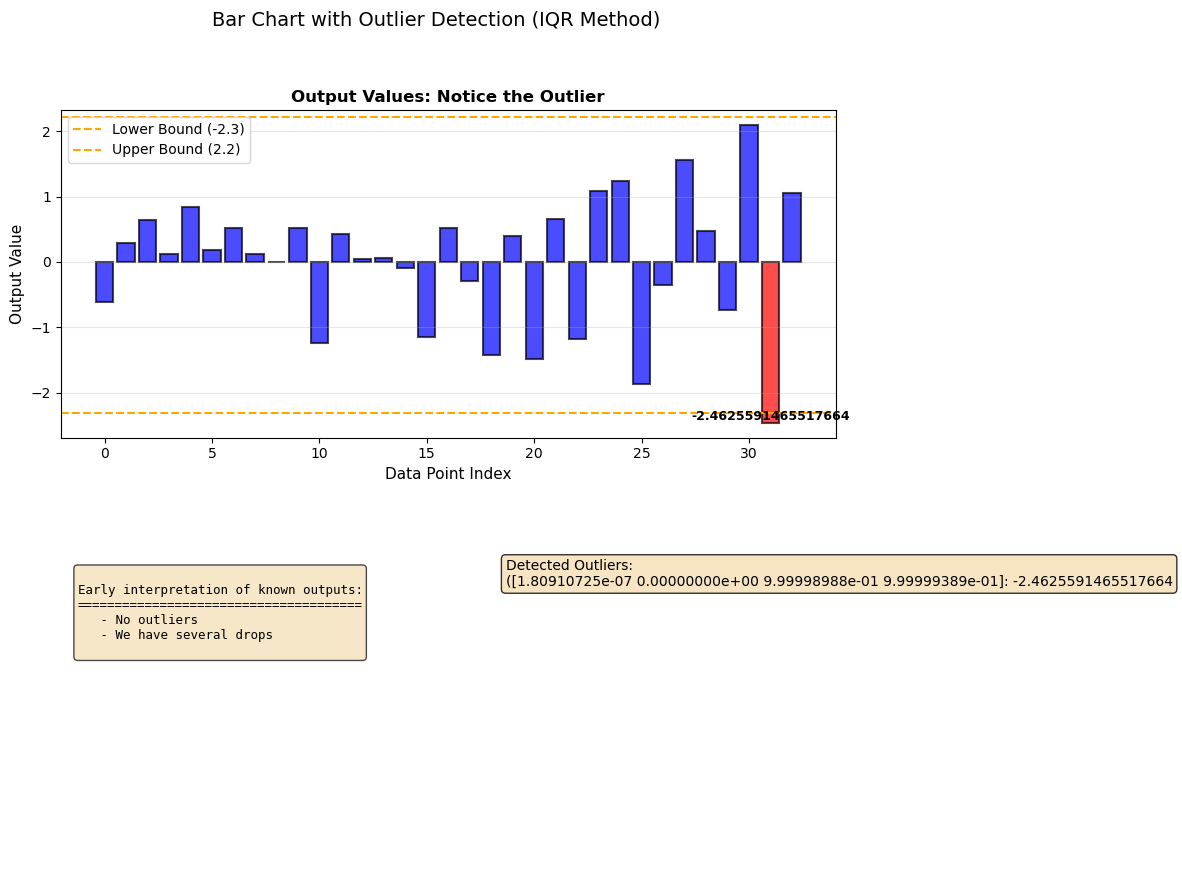

In [5]:
plot_output_outliers(X_train, y_train, "Bar Chart with Outlier Detection (IQR Method)", f"""
Early interpretation of known outputs:
{'='*38}
   - No outliers
   - We have several drops
""")

# 3. Build probabilistic Model

Single GP with ARD Matern 2.5 kernel. The ARD length scales will reveal which dimensions matter most.

In [6]:
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * Matern(
    length_scale=[0.5, 0.5, 0.5, 0.5],
    nu=2.5,
    length_scale_bounds=(1e-3, 1e2)
)

model = GaussianProcessRegressor(
    kernel=kernel,
    alpha=0.01,
    normalize_y=True,
    n_restarts_optimizer=30
)

model.fit(X_train, y_train)
print(f"Optimized Kernel: {model.kernel_}")

# Feature importance from ARD length scales
learned_scales = model.kernel_.k2.length_scale
importance = 1.0 / learned_scales
importance_norm = importance / importance.sum() * 100

print(f"\nFeature Importance (from ARD length scales):")
print(f"{'Dim':<6} {'Length Scale':<15} {'Importance %':<15} {'Role'}")
print("-" * 48)
sorted_dims = np.argsort(learned_scales)
for i in sorted_dims:
    role = 'IMPORTANT' if learned_scales[i] < 2.0 else ('moderate' if learned_scales[i] < 10.0 else 'noise')
    print(f"x{i+1:<5} {learned_scales[i]:<15.4f} {importance_norm[i]:<15.1f} {role}")

# Identify most/least important dims for interactive plotting
most_important = sorted_dims[:2]  # 2 shortest length scales = most important
least_important = sorted_dims[2:]  # 2 longest = least important (fixed in sliders)
print(f"\nPlotting dims: x{most_important[0]+1}, x{most_important[1]+1} (most important)")
print(f"Slider dims: x{least_important[0]+1}, x{least_important[1]+1} (least important)")

Optimized Kernel: 4.16**2 * Matern(length_scale=[2, 2.06, 2.05, 2.05], nu=2.5)

Feature Importance (from ARD length scales):
Dim    Length Scale    Importance %    Role
------------------------------------------------
x1     1.9988          25.5            IMPORTANT
x3     2.0481          24.9            moderate
x4     2.0512          24.8            moderate
x2     2.0568          24.8            moderate

Plotting dims: x1, x3 (most important)
Slider dims: x4, x2 (least important)


# 4. Interactive GP Visualization

Fix the 2 least important dimensions with sliders, and view contour plots of the 2 most important dimensions.

In [7]:
n_grid_2d = 40
x_plot_1 = np.linspace(0, 1, n_grid_2d)
x_plot_2 = np.linspace(0, 1, n_grid_2d)
X1_plot, X2_plot = np.meshgrid(x_plot_1, x_plot_2)

dim_a, dim_b = most_important[0], most_important[1]
dim_c, dim_d = least_important[0], least_important[1]

def plot_gp_slice(fix_c=0.5, fix_d=0.5):
    # Build full 4D grid with 2 dims varying and 2 fixed
    grid_4d = np.zeros((n_grid_2d * n_grid_2d, 4))
    grid_4d[:, dim_a] = X1_plot.ravel()
    grid_4d[:, dim_b] = X2_plot.ravel()
    grid_4d[:, dim_c] = fix_c
    grid_4d[:, dim_d] = fix_d
    
    mu, sigma = model.predict(grid_4d, return_std=True)
    
    fixed_info = f'x{dim_c+1}={fix_c:.2f}, x{dim_d+1}={fix_d:.2f}'
    plot_nd_mean_uncertainty_slice(
        X_train, X1_plot, X2_plot,
        mu.reshape(n_grid_2d, n_grid_2d),
        sigma.reshape(n_grid_2d, n_grid_2d),
        dim1_idx=dim_a, dim2_idx=dim_b,
        title_prefix='GP Mean & Uncertainty',
        fixed_info=fixed_info
    )

interact(
    plot_gp_slice,
    fix_c=FloatSlider(min=0, max=1, step=0.05, value=0.5, description=f'x{dim_c+1}'),
    fix_d=FloatSlider(min=0, max=1, step=0.05, value=0.5, description=f'x{dim_d+1}')
)

interactive(children=(FloatSlider(value=0.5, description='x4', max=1.0, step=0.05), FloatSlider(value=0.5, des…

<function __main__.plot_gp_slice(fix_c=0.5, fix_d=0.5)>

# 5. Acquisition Function (UCB on LHS candidates)

Replace the coarse meshgrid with Latin Hypercube Sampling to get 10,000 well-distributed candidates across all 4 dimensions. This avoids the boundary-bias issue of coarse grids in 4D.

In [8]:
def upper_confidence_bound(mu, sigma, kappa=2.0):
    return mu + kappa * sigma

# Generate LHS candidates
sampler = LatinHypercube(d=4, seed=42)
X_candidates = sampler.random(n=10_000)  # 10K points in [0,1]^4

# GP predictions on candidates
mu_cand, sigma_cand = model.predict(X_candidates, return_std=True)

# UCB acquisition
kappa = 5.0
ucb_values = upper_confidence_bound(mu_cand, sigma_cand, kappa=kappa)

best_idx = np.argmax(ucb_values)
x_next_norm = X_candidates[best_idx]
x_next_orig = scaler_X.inverse_transform([x_next_norm])[0]

print(f"{'='*71}")
print(f"RECOMMENDED NEXT POINT (UCB, kappa={kappa}, 10K LHS candidates)")
print(f"{'='*71}")
print(f"  Input (original space): {np.array_str(x_next_orig, precision=6)}")

y_pred, y_std = model.predict([x_next_norm], return_std=True)
print(f"  GP prediction: {y_pred[0]:.4f} +/- {y_std[0]:.4f}")
print(f"  UCB value: {ucb_values[best_idx]:.4f}")

print(f"\nSanity check - is this a corner?")
for i in range(4):
    at_boundary = x_next_norm[i] < 0.02 or x_next_norm[i] > 0.98
    print(f"  x{i+1} = {x_next_norm[i]:.4f} {'<-- BOUNDARY!' if at_boundary else ''}")

print(f"\nCurrent best: {X_train_raw[np.argmax(y_train_raw)]} (y = {y_train_raw.max():.6f})")

RECOMMENDED NEXT POINT (UCB, kappa=5.0, 10K LHS candidates)
  Input (original space): [0.364795 0.410705 0.409173 0.459272]
  GP prediction: 1.9425 +/- 0.0962
  UCB value: 2.4237

Sanity check - is this a corner?
  x1 = 0.3450 
  x2 = 0.4428 
  x3 = 0.4091 
  x4 = 0.4115 

Current best: [0.43274  0.424865 0.378558 0.387505] (y = 0.401305)
